In [1]:
import os

import numpy as np
import pandas as pd

from utils.plot import plt

In [2]:
from ESG.config import PROCESSED_DATA_DIR, FIGURE_DIR, RESULT_DIR
from utils.data_porter import save_to_csv

In [3]:
esg_alter = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'sz_esg_alter_events.csv'),
                        dtype={'INDICATOR_CODE': str, 'TICKER': str},
                        parse_dates=['OCCUR_DATE', 'PUBLISH_DATE'])
esg_alter = esg_alter[['SECURITY_NAME', 'TICKER', 'INDICATOR_CODE', 'POLARITY', 'ESG_TYPE', 'EVENT_TYPE',
                       'NUM_VALUE', 'PUBLISH_DATE', 'OCCUR_DATE', 'PROVINCE', 'CITY']]

In [4]:
esg_alter['INDICATOR_LEVEL1'] = esg_alter['INDICATOR_CODE'].apply(lambda x: x[:3])
esg_alter['INDICATOR_LEVEL2'] = esg_alter['INDICATOR_CODE'].apply(lambda x: x[:6])

In [5]:
esg_alter['OCCUR_YEAR'] = esg_alter['OCCUR_DATE'].apply(lambda x: x.year)
esg_alter['PUBLISH_YEAR'] = esg_alter['PUBLISH_DATE'].apply(lambda x: x.year)

In [6]:
esg_alter.isna().sum()

SECURITY_NAME            0
TICKER                   0
INDICATOR_CODE           0
POLARITY                 0
ESG_TYPE                 0
EVENT_TYPE           15229
NUM_VALUE                0
PUBLISH_DATE        181541
OCCUR_DATE               0
PROVINCE            170259
CITY                176614
INDICATOR_LEVEL1         0
INDICATOR_LEVEL2         0
OCCUR_YEAR               0
PUBLISH_YEAR        181541
dtype: int64

In [7]:
event_num = esg_alter.loc[~esg_alter['EVENT_TYPE'].isna(), :].groupby(by=['EVENT_TYPE']).apply(len).sort_values(ascending=False)
top_event_types = event_num.index[:20]
# esg_alter['top_event_types'] = esg_alter['EVENT']

In [ ]:
pd.unique(esg_alter[esg_alter['POLARITY'] == 'POSITIVE']['EVENT_TYPE'])

In [17]:
from functools import reduce

def split(event_type):
    res = list()
    event_ = event_type.split(',')
    for e in event_:
        res.extend(e.split('/'))
    return res
    
def split_event_type(type):
    return reduce(lambda x, y: set(x).union(set(y)), 
           esg_alter[esg_alter['ESG_TYPE']==type].loc[~esg_alter['EVENT_TYPE'].isna(), 
                                                      'EVENT_TYPE'].apply(split))

In [18]:
event_types = dict()
event_types['E'] = split_event_type('E')
event_types['S'] = split_event_type('S')
event_types['G'] = split_event_type('G')

In [10]:
esg_alter.groupby('ESG_TYPE').apply(len)

ESG_TYPE
E     26401
G    172661
S      2808
dtype: int64

In [11]:
esg_alter['OCCUR_YEAR_'] = esg_alter['OCCUR_YEAR'].apply(lambda x: '2010前' if x < 2010 else x)
year_type_count = esg_alter.groupby(by=['OCCUR_YEAR_', 'ESG_TYPE']).apply(len)

In [12]:
esg_alter.groupby('OCCUR_YEAR').apply(len)

OCCUR_YEAR
1993        1
1997        1
1998        1
1999      149
2000      142
2001      171
2002      157
2003      111
2004      164
2005      252
2006      251
2007      257
2008      292
2009      383
2010      382
2011      859
2012      798
2013     2969
2014    12534
2015    18298
2016    26770
2017    35673
2018    42559
2019    53726
2020     4967
2021        3
dtype: int64

In [13]:
yt_df = pd.DataFrame(np.zeros((12, 3)), columns=('G', 'E', 'S'), index=['2010前'] + list(range(2010, 2021)))

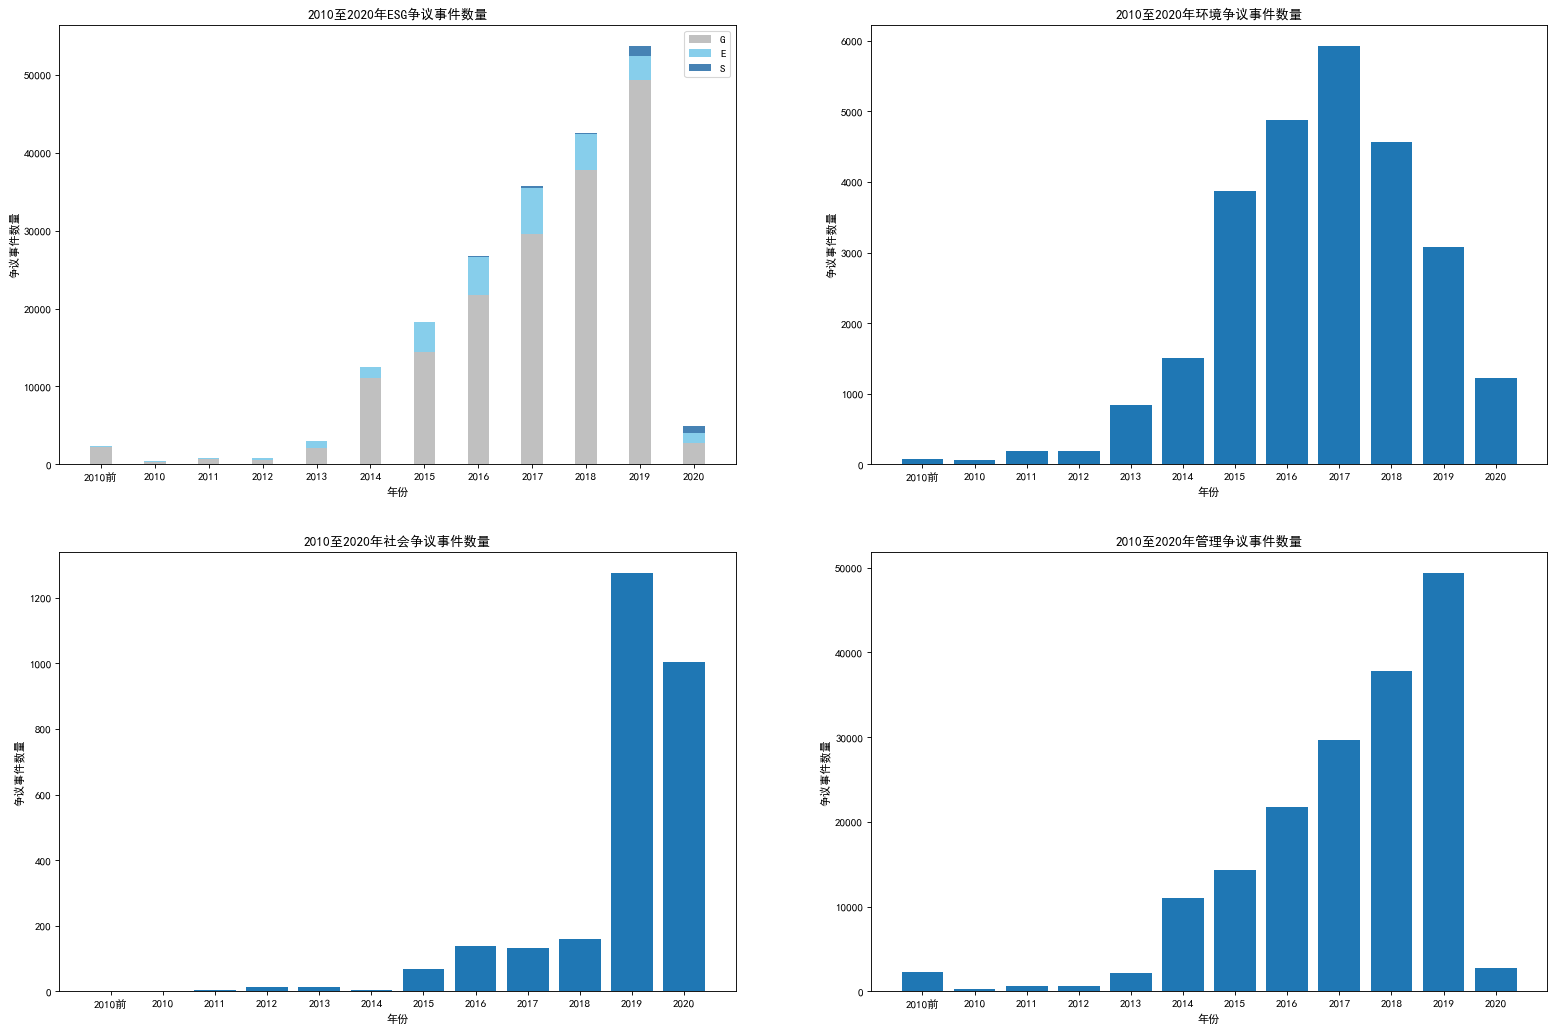

In [22]:
fig = plt.figure(figsize=(24, 16), dpi=80)

plt.subplot(221)
for i, year in enumerate(['2010前'] + list(range(2010, 2021))):
    bot = 0
    for type, color in zip(('G', 'E', 'S'), ('#C0C0C0', '#87CEEB', '#4682B4')):
        try:
            h = year_type_count[year][type]
        except KeyError:
            h = 0
        yt_df.loc[year, type] = h
        if i == 0:
            plt.bar(2 * i, h, bottom=bot, color=color, label=type)
        else:
            plt.bar(2 * i, h, bottom=bot, color=color)
        bot += h
plt.xticks(2 * np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年ESG争议事件数量')
plt.legend()

plt.subplot(222)
plt.bar(np.arange(12), yt_df.loc[:, 'E'])
plt.xticks(np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年环境争议事件数量')

plt.subplot(223)
plt.bar(np.arange(12), yt_df.loc[:, 'S'])
plt.xticks(np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年社会争议事件数量')

plt.subplot(224)
plt.bar(np.arange(12), yt_df.loc[:, 'G'])
plt.xticks(np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年管理争议事件数量')

plt.savefig(os.path.join(FIGURE_DIR, '2010-2020年ESG争议事件数量.png'))

自2010年以来，ESG争议事件数量整体逐年上涨，2020年争议事件数量大幅减少，也可能是由于疫情影响
，仍需进一步观察。在整体ESG争议事件中，管理（Government）事件占比最高；环境（Environment）
争议事件数量次之；社会（Society）争议事件数量最少。

管理争议事件在2014年呈现大幅上升后主要保持线性增长趋势；环境争议事件则在2014年大幅上升之后，
在2017年达到峰值后近年来呈现下降趋势。社会争议事件数量在2018年前增长缓慢，而在2019年大幅上升
。观察数据，可以发现社会争议事件的发布日期均在2019年后，推测可能与政策相关；然而对应列（PUBL
ISH_DATE）缺失值较多，因此结论可能并不可靠。

In [42]:
def count_event_type(type):
    ec_df = pd.DataFrame()
    type_df = esg_alter.loc[esg_alter['ESG_TYPE']==type, 'EVENT_TYPE'].loc[~esg_alter['EVENT_TYPE'].isna()]
    ec_df['EVENT_TYPE'] = list(event_types[type])
    ec_df['COUNTS'] = ec_df['EVENT_TYPE'].apply(lambda t: type_df.apply(lambda x: t in x).sum())
    return ec_df

In [53]:
e_event_count_df = count_event_type('E').sort_values(by=['COUNTS'], inplace=False).reset_index(drop=True)
s_event_count_df = count_event_type('S').sort_values(by=['COUNTS'], inplace=False).reset_index(drop=True)
g_event_count_df = count_event_type('G').sort_values(by=['COUNTS'], inplace=False).reset_index(drop=True)

观察

Text(0.5, 1.0, '环境争议事件各类型累计')

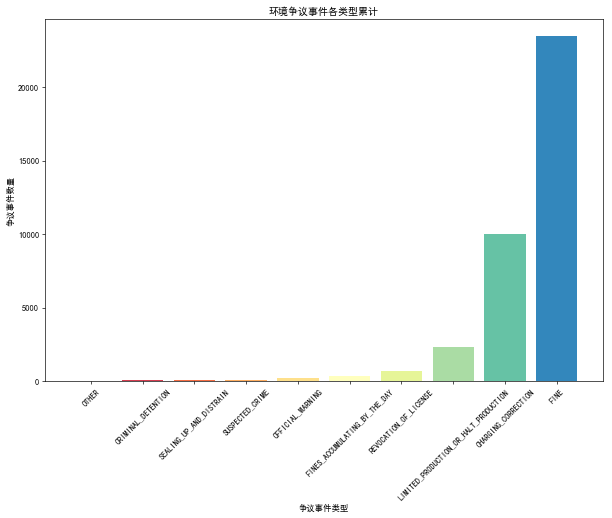

In [58]:
plt.figure(figsize=(12, 8), dpi=60)
colors = [plt.cm.Spectral(i/10) for i in range(10)]
plt.bar(np.arange(10), e_event_count_df['COUNTS'], color=colors)
plt.xticks(np.arange(10), [i[19:] for i in e_event_count_df['EVENT_TYPE']], rotation=45)
plt.xlabel('争议事件类型')
plt.ylabel('争议事件数量')
plt.title('环境争议事件各类型累计')

In [52]:
e_event_count_df['COUNTS']

TypeError: 'NoneType' object is not subscriptable

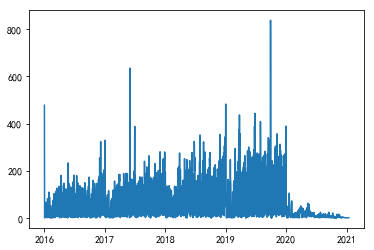

In [61]:
plt.plot(esg_alter[esg_alter['OCCUR_DATE'] >= '2016-01-01'].groupby(by=['OCCUR_DATE']).apply(len))
# esg_alter.groupby(by=['OCCUR_DATE', 'ESG_TYPE']).apply(len)

In [64]:
max(pd.unique(esg_alter['NUM_VALUE']))

525685668.48